In [2]:
import re
import pickle
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# download stopwords and prepare stopword set
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# prepare stemmer for Indonesian text
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# load hoax news and filter true hoaxes
df_hoax = pd.read_csv(
    "../Dataset/hoax_news.csv", usecols=["Title", "Narasi", "category"]
).dropna(subset=["Title", "Narasi", "category"])
df_hoax = df_hoax[~df_hoax["category"].isin(["Benar", "Disinformasi"])]
df_hoax = df_hoax.rename(columns={"Title": "title", "Narasi": "body"})
df_hoax["label"] = "hoax"

# load real news and label
real = pd.read_csv(
    "../Dataset/detik_news.csv", usecols=["page", "title", "url", "content"]
).dropna(subset=["title", "content"])
real = real.rename(columns={"content": "body"})
real["label"] = "real"
real = real[["title", "body", "label"]]

# remove outliers in hoax based on text length
for field in ["title", "body"]:
    lengths = df_hoax[field].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df_hoax = df_hoax[(lengths >= lower) & (lengths <= upper)]

df_hoax = df_hoax.drop(columns=["category"])

# balance classes by downsampling
df = pd.concat([df_hoax, real], ignore_index=True)
min_count = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(
    lambda g: g.sample(min_count, random_state=42)
)

# split into train, validation, and test sets
X = df[["title", "body"]].astype(str)
y = df["label"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
val_fraction = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_fraction, stratify=y_temp, random_state=42
)

# function to clean, tokenize, and stem text
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# prepare token lists for word2vec training
train_sentences = []
for _, row in X_train.iterrows():
    tokens = clean_tokenize(row['title']) + clean_tokenize(row['body'])
    train_sentences.append(tokens)

# train Word2Vec embeddings on training data
w2v_model = Word2Vec(
    sentences=train_sentences,
    vector_size=500,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

# function to compute average embedding for a document
def document_vector(tokens):
    vectors = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

# build feature matrices
def build_features(X_split):
    features = []
    for _, row in X_split.iterrows():
        tokens = clean_tokenize(row['title']) + clean_tokenize(row['body'])
        features.append(document_vector(tokens))
    return np.vstack(features)

X_train_vec = build_features(X_train)
X_val_vec   = build_features(X_val)
X_test_vec  = build_features(X_test)

# encode labels to numeric values
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# train a Gaussian Naive Bayes classifier on embeddings
nb = GaussianNB()
bb = nb.fit(X_train_vec, y_train_enc)

# evaluate on validation set
val_preds = nb.predict(X_val_vec)
print("Validation accuracy:", accuracy_score(y_val_enc, val_preds))
print(classification_report(y_val_enc, val_preds, target_names=le.classes_))
print("Validation confusion matrix:")
print(confusion_matrix(y_val_enc, val_preds))

# evaluate on test set
test_preds = nb.predict(X_test_vec)
print("Test accuracy:", accuracy_score(y_test_enc, test_preds))
print(classification_report(y_test_enc, test_preds, target_names=le.classes_))
print("Test confusion matrix:")
print(confusion_matrix(y_test_enc, test_preds))

# save pipeline components
with open("w2v_nb_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":      nb,
        "w2v_model":  w2v_model,
        "label_encoder": le,
        "stopwords":  stops
    }, f)

print("Saved Word2Vec+NaiveBayes pipeline to w2v_nb_hoax.pkl")


Validation accuracy: 0.8254299114121939
              precision    recall  f1-score   support

        hoax       0.82      0.84      0.83       959
        real       0.83      0.81      0.82       960

    accuracy                           0.83      1919
   macro avg       0.83      0.83      0.83      1919
weighted avg       0.83      0.83      0.83      1919

Validation confusion matrix:
[[802 157]
 [178 782]]
Test accuracy: 0.8175182481751825
              precision    recall  f1-score   support

        hoax       0.79      0.87      0.83       480
        real       0.85      0.77      0.81       479

    accuracy                           0.82       959
   macro avg       0.82      0.82      0.82       959
weighted avg       0.82      0.82      0.82       959

Test confusion matrix:
[[416  64]
 [111 368]]
Saved Word2Vec+NaiveBayes pipeline to w2v_nb_hoax.pkl


OOD Results for Word2Vec + Naive Bayes
Accuracy: 0.8133333333333334
              precision    recall  f1-score   support

        hoax      0.765     0.938     0.843        80
        real      0.904     0.671     0.770        70

    accuracy                          0.813       150
   macro avg      0.835     0.804     0.807       150
weighted avg      0.830     0.813     0.809       150



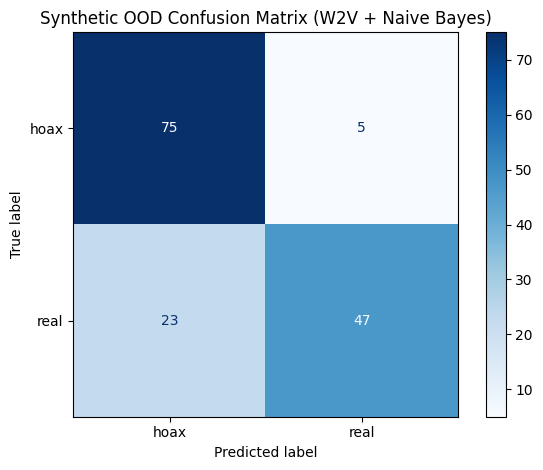

In [3]:
# test_w2v_nb_synthetic.py

import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

# ensure stopwords are available
nltk.download("stopwords", quiet=True)

# load the trained pipeline
with open("w2v_nb_hoax.pkl", "rb") as f:
    data          = pickle.load(f)
    nb_model      = data["model"]
    w2v_model     = data["w2v_model"]
    label_encoder = data["label_encoder"]
    stops         = data["stopwords"]

stemmer = SnowballStemmer("english")

def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

def document_vector(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_model.vector_size)

titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

features = []
for t, b in zip(titles, bodies):
    tokens = clean_tokenize(t) + clean_tokenize(b)
    features.append(document_vector(tokens))
X_syn = np.vstack(features)

preds_numeric = nb_model.predict(X_syn)
preds = label_encoder.inverse_transform(preds_numeric)

print("OOD Results for Word2Vec + Naive Bayes")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

cm = confusion_matrix(true_labels, preds, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Synthetic OOD Confusion Matrix (W2V + Naive Bayes)")
plt.tight_layout()
plt.show()
